In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


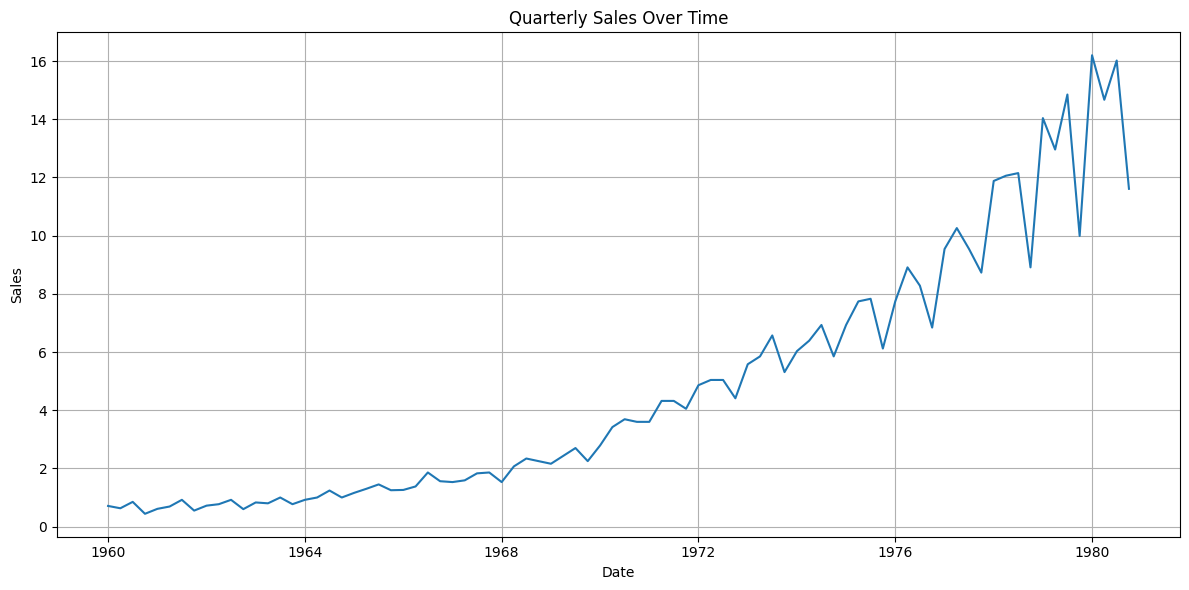

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reload dataset
data_path = '/content/drive/MyDrive/ML Work/Assignment /jj.csv'
data = pd.read_csv(data_path)
data.columns = ['date', 'sales']   # Rename columns for consistency
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Plot original time series
plt.plot(data.index, data['sales'])
plt.title('Quarterly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("ADF Test after Differencing:")
for diff_order in range(1, 3):
    diff_series = data['sales'].diff(diff_order).dropna()
    adf_pval = adfuller(diff_series)[1]
    print(f"  Order {diff_order} differencing: p-value = {adf_pval:.5f}")

ADF Test after Differencing:
  Order 1 differencing: p-value = 0.90885
  Order 2 differencing: p-value = 0.97047


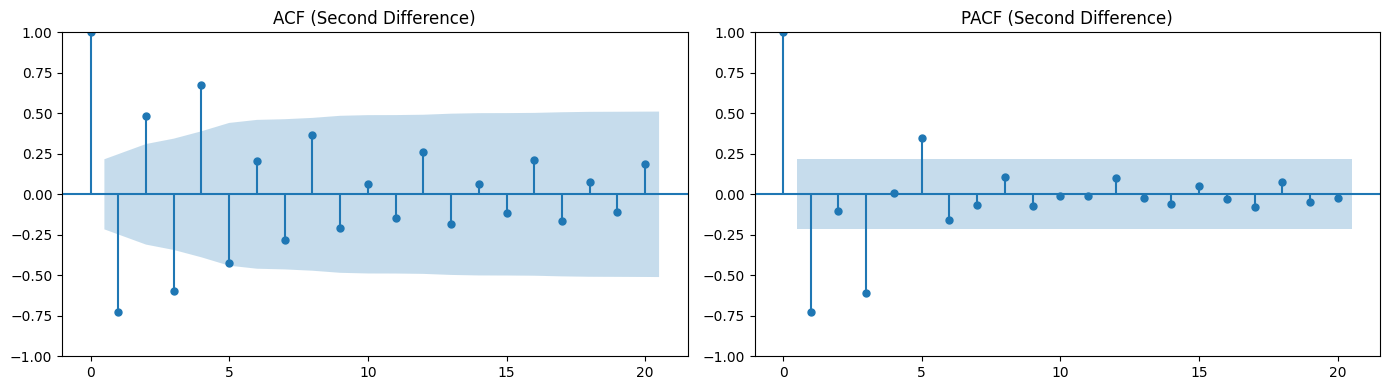

In [ ]:
# Use 2nd order differencing for analysis
diff2_series = data['sales'].diff().dropna().diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(diff2_series, lags=20, ax=axes[0])
axes[0].set_title("ACF (Second Difference)")
plot_pacf(diff2_series, lags=20, ax=axes[1])
axes[1].set_title("PACF (Second Difference)")
plt.tight_layout()
plt.show()

In [ ]:
# Grid Search for ARIMA (p,2,q)
lowest_aic = float("inf")
best_order = None
best_arima = None

for p in range(4):
    for q in range(4):
        try:
            arima_model = ARIMA(data['sales'], order=(p, 2, q)).fit()
            if arima_model.aic < lowest_aic:
                lowest_aic = arima_model.aic
                best_order = (p, 2, q)
                best_arima = arima_model
        except Exception as e:
            continue
print("Best ARIMA order (p, d=2, q):", best_order)

Best ARIMA order (p, d=2, q): (3, 2, 3)


In [ ]:
data['SMA_6'] = data['sales'].rolling(window=6).mean()
data['SMA_12'] = data['sales'].rolling(window=12).mean()
data['EWMA_12'] = data['sales'].ewm(span=12, adjust=False).mean()

In [ ]:
test_periods = 24  # Last 24 quarters for testing
train = data.iloc[:-test_periods]
test = data.iloc[-test_periods:]

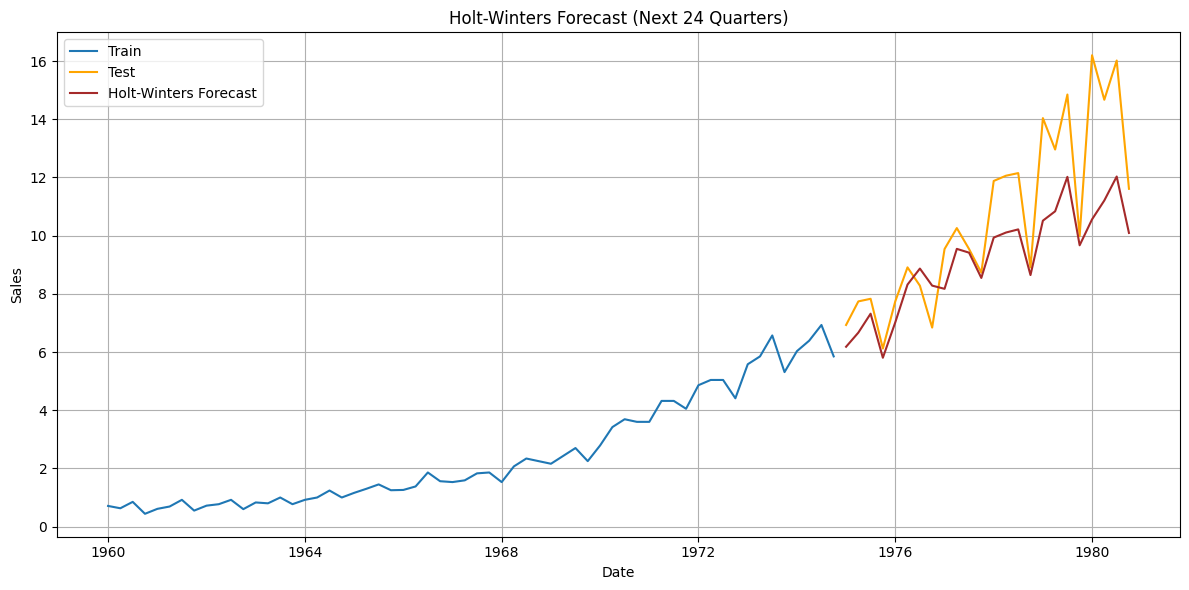

Holt-Winters Evaluation:
 MAE = 1.579, MSE = 4.428, RMSE = 2.104


In [ ]:
# Holt-Winters Model & Forecasting
holt_winters = ExponentialSmoothing(
    train['sales'], trend='add', seasonal='mul', seasonal_periods=24
).fit()
hw_forecast = holt_winters.forecast(test_periods)
hw_forecast_index = pd.date_range(start=test.index[0], periods=test_periods, freq='Q')
hw_forecast_series = pd.Series(hw_forecast.values, index=test.index, name='HW_Forecast')

plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test', color='orange')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Holt-Winters Forecast', color='brown')
plt.title('Holt-Winters Forecast (Next 24 Quarters)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
common_idx = hw_forecast_series.index.intersection(test.index)
hw_mae = mean_absolute_error(test.loc[common_idx, 'sales'], hw_forecast_series.loc[common_idx])
hw_mse = mean_squared_error(test.loc[common_idx, 'sales'], hw_forecast_series.loc[common_idx])
hw_rmse = np.sqrt(hw_mse)
print("Holt-Winters Evaluation:\n MAE = {:.3f}, MSE = {:.3f}, RMSE = {:.3f}".format(hw_mae, hw_mse, hw_rmse))

**Build an RNN based model (LSTM)**

In [ ]:
# Scale sales values for LSTM
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(data[['sales']])

# Prepare sequences for LSTM input
def create_lstm_sequences(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

lstm_window = 12  # 12 quarters (3 years)
X_lstm, y_lstm = create_lstm_sequences(sales_scaled, window_size=lstm_window)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Split for train/test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

# Build and train LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=8,
               validation_data=(X_test_lstm, y_test_lstm),
               callbacks=[lstm_early_stop], verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0552 - val_loss: 0.1076
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0174
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0410
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027 - val_loss: 0.0225
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.0171
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0167
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0174
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0190
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0162
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0207
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0163
Epoc

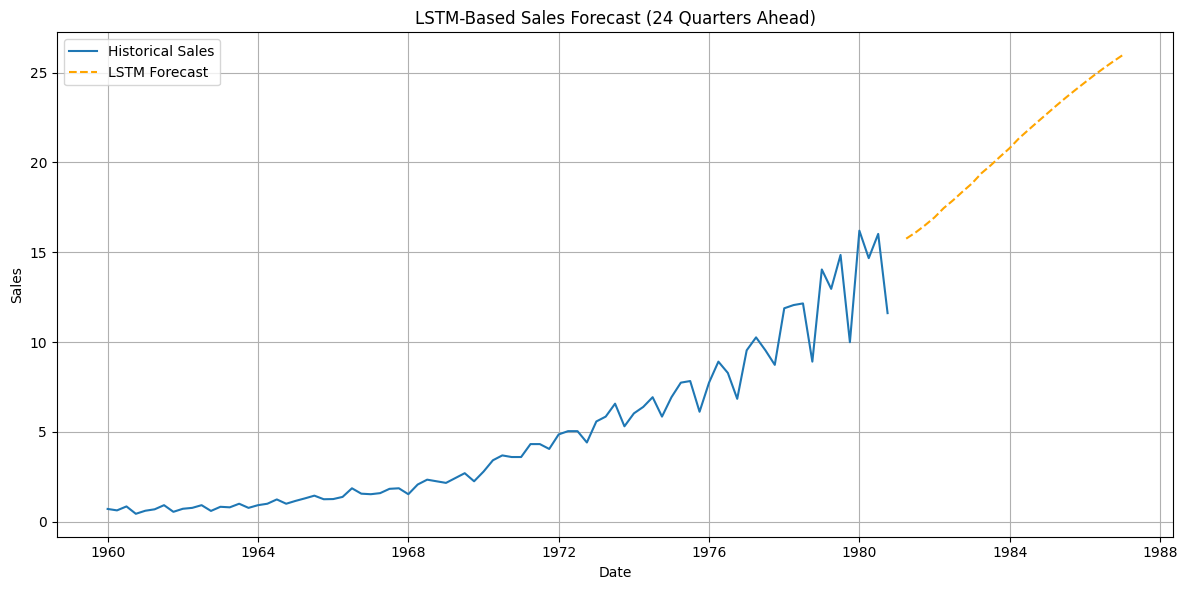

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
LSTM Test Evaluation:
 MAE = 1.623, RMSE = 2.006, MAPE = 0.142


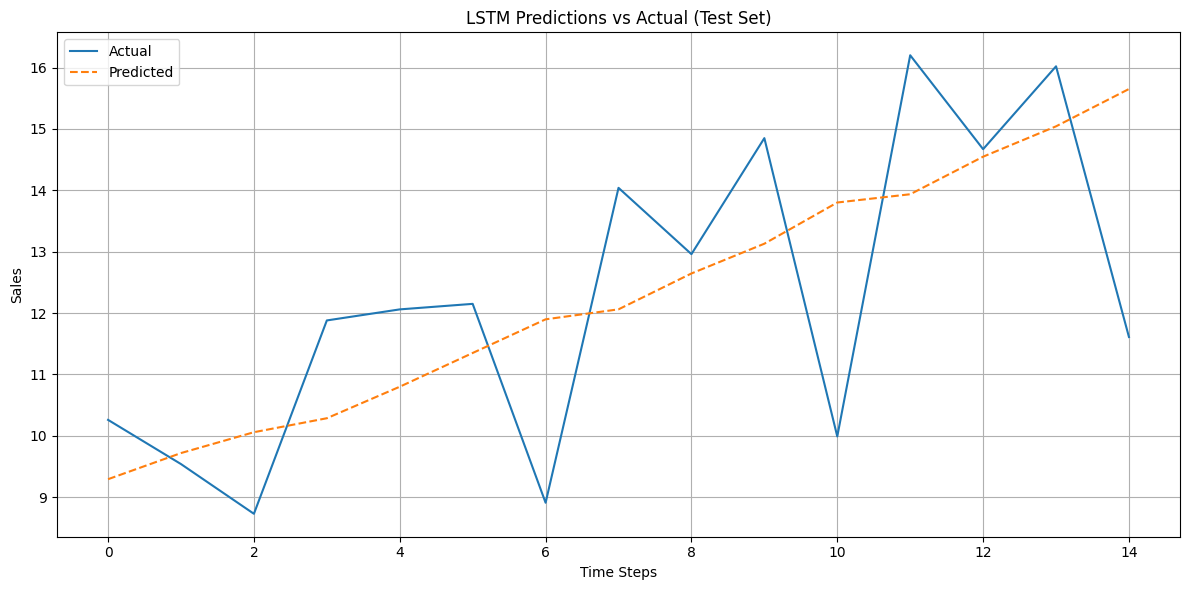

In [ ]:
# Function to forecast future steps using LSTM
def forecast_lstm(model, last_seq, scaler, steps=24, window=12):
    seq = last_seq[-window:].reshape(1, window, 1)
    preds = []
    for _ in range(steps):
        pred = model.predict(seq, verbose=0)[0][0]
        preds.append(pred)
        seq = np.append(seq[:, 1:, :], [[[pred]]], axis=1)
    return scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# LSTM Forecast (24 quarters ahead)
lstm_forecast_vals = forecast_lstm(lstm_model, sales_scaled, scaler, steps=24, window=lstm_window)
lstm_future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=24, freq='Q')
lstm_forecast_df = pd.DataFrame(lstm_forecast_vals, index=lstm_future_index, columns=['Forecast'])

# Plot LSTM forecast
plt.plot(data.index, data['sales'], label='Historical Sales')
plt.plot(lstm_forecast_df.index, lstm_forecast_df['Forecast'], '--', label='LSTM Forecast', color='orange')
plt.title('LSTM-Based Sales Forecast (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM evaluation
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred_actual = scaler.inverse_transform(lstm_pred_scaled)
lstm_test_actual = scaler.inverse_transform(y_test_lstm)
lstm_mae = mean_absolute_error(lstm_test_actual, lstm_pred_actual)
lstm_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_pred_actual))
lstm_mape = mean_absolute_percentage_error(lstm_test_actual, lstm_pred_actual)
print("LSTM Test Evaluation:\n MAE = {:.3f}, RMSE = {:.3f}, MAPE = {:.3f}".format(lstm_mae, lstm_rmse, lstm_mape))

# Optional: Plot predicted vs actual for LSTM
plt.plot(lstm_test_actual, label='Actual')
plt.plot(lstm_pred_actual, '--', label='Predicted')
plt.title('LSTM Predictions vs Actual (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Build an RNN based model (GRU)**

In [ ]:
# Prepare sequences for GRU input (use 6 time steps)
def create_gru_sequences(series, n_input=6):
    X, y = [], []
    for i in range(len(series) - n_input):
        X.append(series[i:i+n_input])
        y.append(series[i+n_input])
    return np.array(X), np.array(y)

X_gru, y_gru = create_gru_sequences(sales_scaled, n_input=6)
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, shuffle=False)

# Reshape for GRU
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0], X_train_gru.shape[1], 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0], X_test_gru.shape[1], 1)

# Build and train GRU model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mae')
gru_history = gru_model.fit(
    X_train_gru, y_train_gru, epochs=50, batch_size=8,
    validation_data=(X_test_gru, y_test_gru), shuffle=False, verbose=2
)



Epoch 1/50
8/8 - 3s - 333ms/step - loss: 0.0774 - val_loss: 0.2934
Epoch 2/50
8/8 - 0s - 11ms/step - loss: 0.1129 - val_loss: 0.1832
Epoch 3/50
8/8 - 0s - 19ms/step - loss: 0.0899 - val_loss: 0.2495
Epoch 4/50
8/8 - 0s - 16ms/step - loss: 0.0564 - val_loss: 0.1761
Epoch 5/50
8/8 - 0s - 18ms/step - loss: 0.0285 - val_loss: 0.0954
Epoch 6/50
8/8 - 0s - 18ms/step - loss: 0.0321 - val_loss: 0.1042
Epoch 7/50
8/8 - 0s - 16ms/step - loss: 0.0260 - val_loss: 0.0957
Epoch 8/50
8/8 - 0s - 17ms/step - loss: 0.0312 - val_loss: 0.1236
Epoch 9/50
8/8 - 0s - 11ms/step - loss: 0.0333 - val_loss: 0.1216
Epoch 10/50
8/8 - 0s - 18ms/step - loss: 0.0420 - val_loss: 0.1235
Epoch 11/50
8/8 - 0s - 18ms/step - loss: 0.0275 - val_loss: 0.1173
Epoch 12/50
8/8 - 0s - 11ms/step - loss: 0.0359 - val_loss: 0.1278
Epoch 13/50
8/8 - 0s - 12ms/step - loss: 0.0316 - val_loss: 0.1195
Epoch 14/50
8/8 - 0s - 11ms/step - loss: 0.0307 - val_loss: 0.1090
Epoch 15/50
8/8 - 0s - 12ms/step - loss: 0.0295 - val_loss: 0.1036
Epo

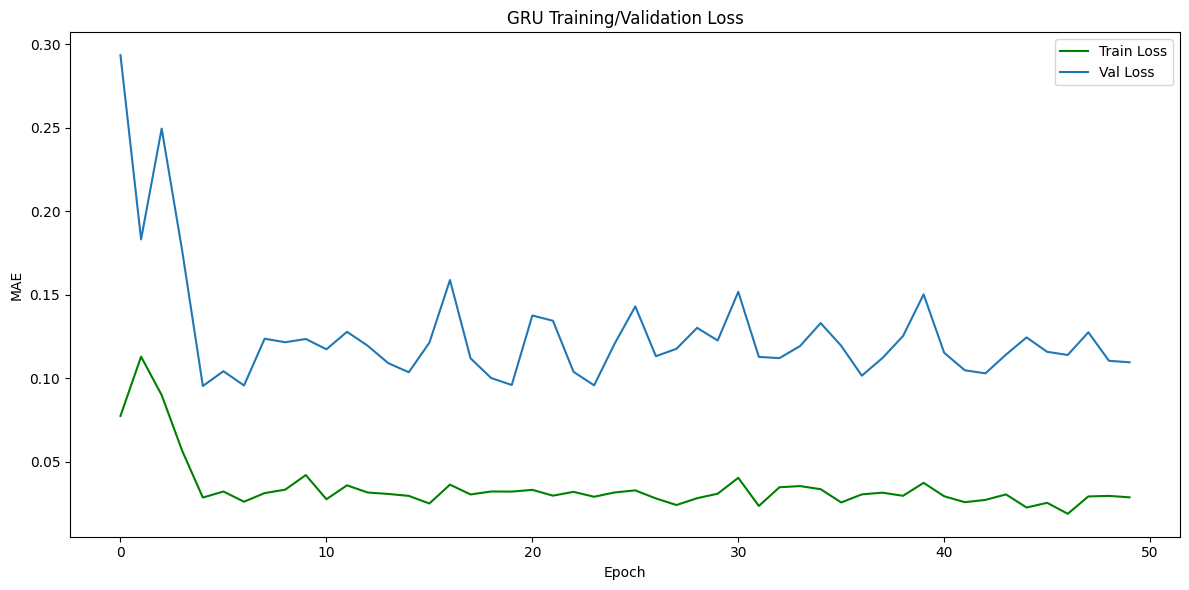

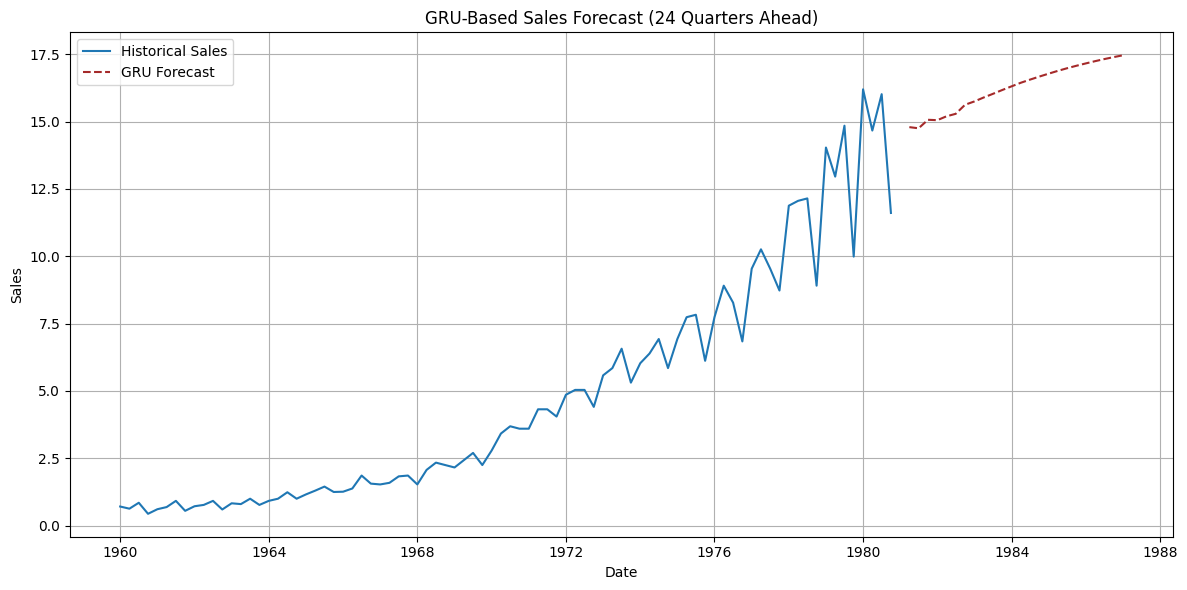

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
GRU Test Evaluation:
 MAE = 1.726, MSE = 3.945, RMSE = 1.986, R2 = 0.326


In [ ]:
# Plot training/validation loss for GRU
plt.plot(gru_history.history['loss'], label='Train Loss', color='green')
plt.plot(gru_history.history['val_loss'], label='Val Loss')
plt.title('GRU Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# GRU Forecasting (24 quarters)
last_gru_seq = sales_scaled[-6:]
gru_forecasts = []
for _ in range(24):
    input_seq = last_gru_seq.reshape(1, 6, 1)
    pred = gru_model.predict(input_seq, verbose=0)[0][0]
    gru_forecasts.append(pred)
    last_gru_seq = np.append(last_gru_seq[1:], [[pred]], axis=0)
gru_forecast_vals = scaler.inverse_transform(np.array(gru_forecasts).reshape(-1, 1))
gru_future_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=24, freq='Q')
gru_forecast_df = pd.DataFrame(gru_forecast_vals, index=gru_future_index, columns=['Forecast'])

plt.plot(data.index, data['sales'], label='Historical Sales')
plt.plot(gru_forecast_df.index, gru_forecast_df['Forecast'], '--', label='GRU Forecast', color='brown')
plt.title('GRU-Based Sales Forecast (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# GRU evaluation
gru_pred_scaled = gru_model.predict(X_test_gru)
gru_pred_actual = scaler.inverse_transform(gru_pred_scaled)
gru_test_actual = scaler.inverse_transform(y_test_gru)
gru_mae = mean_absolute_error(gru_test_actual, gru_pred_actual)
gru_mse = mean_squared_error(gru_test_actual, gru_pred_actual)
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(gru_test_actual, gru_pred_actual)
print("GRU Test Evaluation:\n MAE = {:.3f}, MSE = {:.3f}, RMSE = {:.3f}, R2 = {:.3f}".format(
    gru_mae, gru_mse, gru_rmse, gru_r2
))